# Load forecasting benchmark

Example created by Wilson Rocha Lacerda Junior

## Note

The following example is **not** intended to say that one library is better than another. The main focus of these examples is to show that SysIdentPy can be a good alternative for people looking to model time series.

We will compare the results obtained against **neural prophet** library.

For the sake of brevity, from **SysIdentPy** only the **MetaMSS**, **AOLS** and **FROLS** (with polynomial base function) methods will be used. See the SysIdentPy documentation to learn other ways of modeling with the library.


We will compare a 1-step ahead forecaster on electricity consumption of a building. The config of the neuralprophet model was taken from the neuralprophet documentation (https://neuralprophet.com/html/example_links/energy_data_example.html)

The training will occur on 80% of the data, reserving the last 20% for the validation.

Note: the data used in this example can be found in neuralprophet github.

# Benchmark results:

| No. | Package | Mean Squared Error |
| --- | ------- | ----------------- |
| 1 | SysIdentPy (FROLS) | 4183 |
| 2 | SysIdentPy (MetaMSS) | 5264 |
| 3 | SysIdentPy (AOLS) | 5264 |
| 4 | NeuralProphet | 11471 |

In [1]:
from warnings import simplefilter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sysidentpy.model_structure_selection import FROLS
from sysidentpy.model_structure_selection import AOLS
from sysidentpy.model_structure_selection import MetaMSS
from sysidentpy.basis_function import Polynomial
from sysidentpy.utils.plotting import plot_results
from sysidentpy.neural_network import NARXNN
from sysidentpy.metrics import mean_squared_error

from sktime.datasets import load_airline
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed


simplefilter("ignore", FutureWarning)
np.seterr(all="ignore")

%matplotlib inline

loss = mean_squared_error

data_location = r".\datasets"

c:\Users\wilso\miniconda3\envs\neural_prophet\lib\site-packages\sktime\datatypes\_series\_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
c:\Users\wilso\miniconda3\envs\neural_prophet\lib\site-packages\sktime\datatypes\_panel\_check.py:45: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
c:\Users\wilso\miniconda3\envs\neural_prophet\lib\site-packages\sktime\datatypes\_panel\_check.py:46: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_MULTIINDEX_TYPES = (pd.Int64Index, pd.RangeIndex)


## FROLS

c:\Users\wilso\miniconda3\envs\neural_prophet\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:569: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5
  self.info_values = self.information_criterion(reg_matrix, y)


4183.359498155755


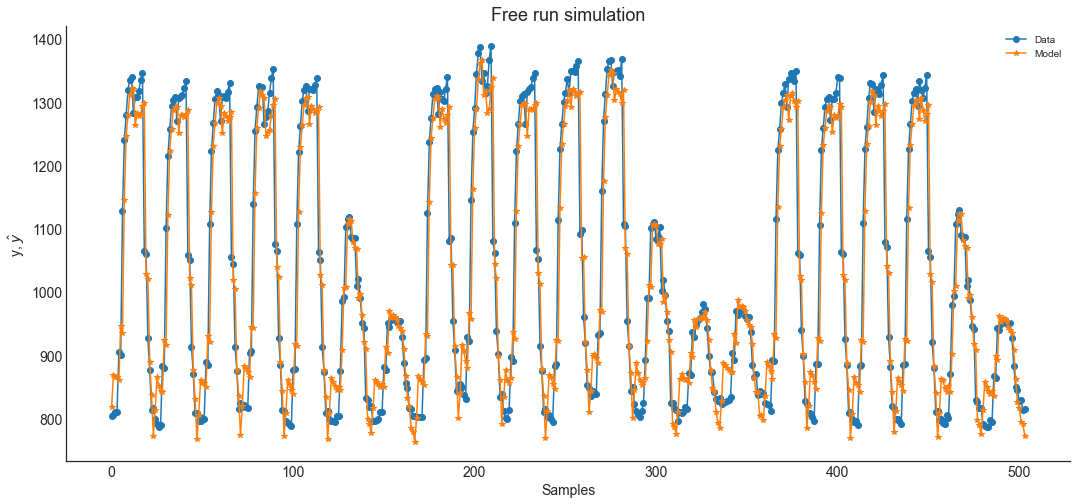

In [2]:
files = ["\SanFrancisco_Hospital.csv"]
raw = pd.read_csv(data_location + files[0])
df = pd.DataFrame()
df["ds"] = pd.date_range("1/1/2015 1:00:00", freq=str(60) + "Min", periods=(8760))
df["y"] = raw.iloc[:, 0].values

df_train, df_val = df.iloc[:7008, :], df.iloc[7008:, :]

y = df["y"].values.reshape(-1, 1)
y_train = df_train["y"].values.reshape(-1, 1)
y_test = df_val["y"].values.reshape(-1, 1)

x_train = df_train["ds"].dt.hour.values.reshape(-1, 1)
x_test = df_val["ds"].dt.hour.values.reshape(-1, 1)

basis_function = Polynomial(degree=1)
sysidentpy = FROLS(
    order_selection=True,
    info_criteria="bic",
    estimator="least_squares",
    basis_function=basis_function,
)
sysidentpy.fit(X=x_train, y=y_train)
x_test = np.concatenate([x_train[-sysidentpy.max_lag :], x_test])
y_test = np.concatenate([y_train[-sysidentpy.max_lag :], y_test])

yhat = sysidentpy.predict(X=x_test, y=y_test, steps_ahead=1)
sysidentpy_loss = loss(
    pd.Series(y_test.flatten()[sysidentpy.max_lag :]),
    pd.Series(yhat.flatten()[sysidentpy.max_lag :]),
)
print(sysidentpy_loss)


plot_results(y=y_test[-504:], yhat=yhat[-504:], n=504, figsize=(18, 8))

## MetaMSS

In [3]:
df.shape

(8760, 2)

5264.434488104671


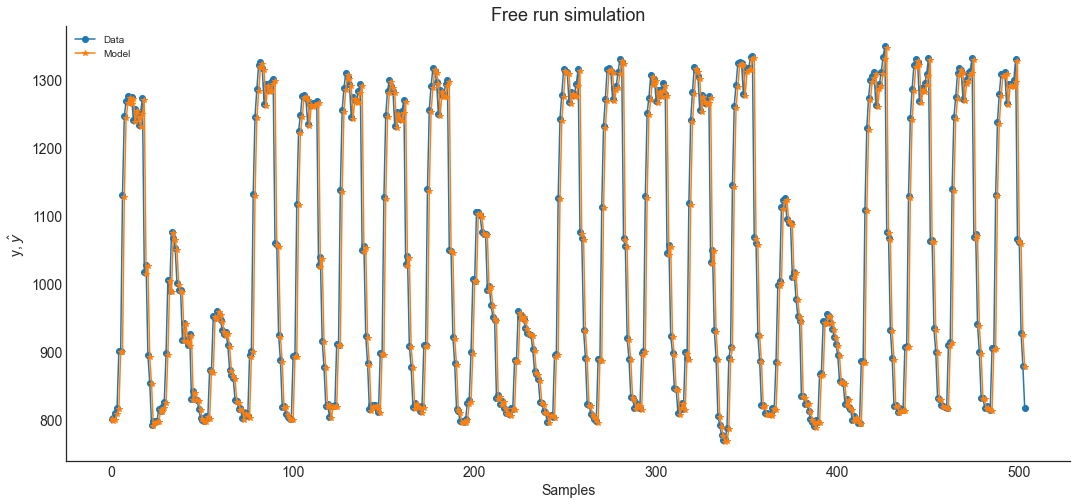

In [10]:
files = ["\SanFrancisco_Hospital.csv"]
raw = pd.read_csv(data_location + files[0])
df = pd.DataFrame()
df["ds"] = pd.date_range("1/1/2015 1:00:00", freq=str(60) + "Min", periods=(8760))
df["y"] = raw.iloc[:, 0].values

x_train, x_test, x_validation, _ = np.split(df["ds"].dt.hour.values, [5000, 7008, 8760])
y_train, y_test, y_validation, _ = np.split(df["y"].values, [5000, 7008, 8760])

x_train = x_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
x_validation = x_validation.reshape(-1, 1)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_validation = y_validation.reshape(-1, 1)

basis_function = Polynomial(degree=1)
sysidentpy_metamss = MetaMSS(
    xlag=2,
    ylag=2,
    basis_function=basis_function,
    estimator="least_squares",
    steps_ahead=1,
    n_agents=15,
    random_state=42,
)
sysidentpy_metamss.fit(X=x_train, X_test=x_test, y=y_train, y_test=y_test)
x_validation = np.concatenate([x_test[-sysidentpy_metamss.max_lag :], x_validation])
y_validation = np.concatenate([y_test[-sysidentpy_metamss.max_lag :], y_validation])

yhat = sysidentpy_metamss.predict(X=x_validation, y=y_validation, steps_ahead=1)
metamss_loss = loss(
    pd.Series(y_validation.flatten()[sysidentpy_metamss.max_lag :]),
    pd.Series(yhat.flatten()[sysidentpy_metamss.max_lag :]),
)
print(metamss_loss)


plot_results(y=y_validation[:700], yhat=yhat[:700], n=504, figsize=(18, 8))

## AOLS

5264.42917196841


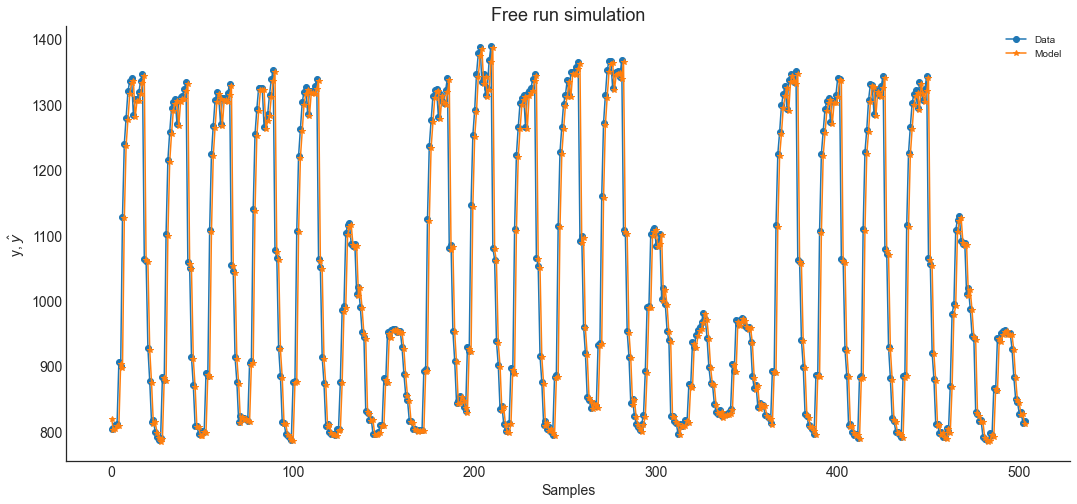

In [11]:
set_random_seed(42)
files = ["\SanFrancisco_Hospital.csv"]
raw = pd.read_csv(data_location + files[0])
df = pd.DataFrame()
df["ds"] = pd.date_range("1/1/2015 1:00:00", freq=str(60) + "Min", periods=(8760))
df["y"] = raw.iloc[:, 0].values

df_train, df_val = df.iloc[:7008, :], df.iloc[7008:, :]

y = df["y"].values.reshape(-1, 1)
y_train = df_train["y"].values.reshape(-1, 1)
y_test = df_val["y"].values.reshape(-1, 1)

x_train = df_train["ds"].dt.hour.values.reshape(-1, 1)
x_test = df_val["ds"].dt.hour.values.reshape(-1, 1)
basis_function = Polynomial(degree=1)
sysidentpy_AOLS = AOLS(xlag=2, ylag=2, basis_function=basis_function)
sysidentpy_AOLS.fit(X=x_train, y=y_train)
x_test = np.concatenate([x_train[-sysidentpy_AOLS.max_lag :], x_test])
y_test = np.concatenate([y_train[-sysidentpy_AOLS.max_lag :], y_test])

yhat = sysidentpy_AOLS.predict(X=x_test, y=y_test, steps_ahead=1)
aols_loss = loss(
    pd.Series(y_test.flatten()[sysidentpy_AOLS.max_lag :]),
    pd.Series(yhat.flatten()[sysidentpy_AOLS.max_lag :]),
)
print(aols_loss)


plot_results(y=y_test[-504:], yhat=yhat[-504:], n=504, figsize=(18, 8))

## Neural Prophet

In [6]:
set_random_seed(42)

# set_log_level("ERROR")
files = ["\SanFrancisco_Hospital.csv"]
raw = pd.read_csv(data_location + files[0])
df = pd.DataFrame()
df["ds"] = pd.date_range("1/1/2015 1:00:00", freq=str(60) + "Min", periods=(8760))
df["y"] = raw.iloc[:, 0].values

m = NeuralProphet(
    n_lags=24, ar_sparsity=0.5, num_hidden_layers=2, d_hidden=20, learning_rate=0.001
)
metrics = m.fit(df, freq="H", valid_p=0.2)

df_train, df_val = m.split_df(df, valid_p=0.2)
m.test(df_val)

future = m.make_future_dataframe(df_val, n_historic_predictions=True)
forecast = m.predict(future)
# fig = m.plot(forecast)
print(loss(forecast["y"][24:-1], forecast["yhat1"][24:-1]))

neuralprophet_loss = loss(forecast["y"][24:-1], forecast["yhat1"][24:-1])

04-26 19:54:06 - WARNING - Parts of code may break if using other than daily data.


INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.


04-26 19:54:06 - INFO - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32


04-26 19:54:06 - INFO - Auto-set batch_size to 32


INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 7


04-26 19:54:06 - INFO - Auto-set epochs to 7


Epoch[7/7]: 100%|██████████| 7/7 [00:03<00:00,  1.82it/s, SmoothL1Loss=0.0102, MAE=81.6, RegLoss=0.011] 
INFO: nprophet - _evaluate: Validation metrics:    SmoothL1Loss    MAE
1         0.011 84.733


04-26 19:54:10 - INFO - Validation metrics:    SmoothL1Loss    MAE
1         0.011 84.733
11397.103026422525


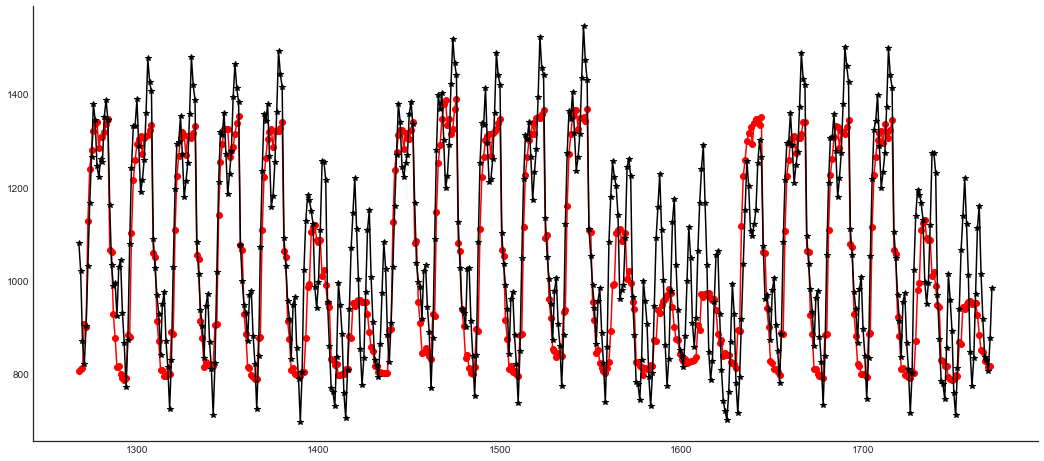

In [7]:
plt.figure(figsize=(18, 8))
plt.plot(forecast["y"][-504:], "ro-")
plt.plot(forecast["yhat1"][-504:], "k*-")

In [8]:
results = {
    "SysIdentPy - FROLS": sysidentpy_loss,
    "SysIdentPy (AOLS)": aols_loss,
    "SysIdentPy (MetaMSS)": metamss_loss,
    "NeuralProphet": neuralprophet_loss,
}

sorted(results.items(), key=lambda result: result[1])

[('SysIdentPy - FROLS', 4183.359498155755),
 ('SysIdentPy (MetaMSS)', 5264.429171346123),
 ('SysIdentPy (AOLS)', 5264.42917196841),
 ('NeuralProphet', 11397.103026422525)]